# Introduction
El presente proyecto consiste en la prediccion del movimiento realizado por un individuo en base a los datos obtenidos de un acelerometro de 3 ejes. Para llevar adelante esta prediccion se cuenta con un set de datos etiquetados.
La estrategia seguida para conseguir la prediccion de los movimientos se baso en las publicaciones de BAI et al (CITA). 
Este autor y otros que validaron su estrategia, trabajan con un diccionario de 'movelets'. Los movelets son secuencias de 10 datos consecutivos para los 3 ejes (ROBAR DESCRIPCION DEL MOVELET). Se toma una muestra de n cantidad de segundos para un movimiento con una etiqueta dada (en mi caso tome 9 segundos) y generan (BUSCAR DESCRIPCION DE COMO SE HACEN LO MOVELETS)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
df_trts = pd.read_csv('train_time_series.csv')
df_trl = pd.read_csv('train_labels.csv')
df2 = pd.merge(df_trts,df_trl, on=['timestamp'], how = 'left')

In [3]:
df2['label']= df2['label'].where(df2['label'].notnull(), 
                                other=df2['label'].fillna(method='ffill'))
df2 = df2[['timestamp','UTC time_x','x','y','z','label']]

In [5]:
df2.head()

,timestamp,UTC time_x,x,y,z,label
0,1565109930787,2019-08-06T16:45:30.787,-0.006485,-0.934860,-0.069046,NaN
1,1565109930887,2019-08-06T16:45:30.887,-0.066467,-1.015442,0.089554,NaN
2,1565109930987,2019-08-06T16:45:30.987,-0.043488,-1.021255,0.178467,NaN
3,1565109931087,2019-08-06T16:45:31.087,-0.053802,-0.987701,0.068985,1.0
4,1565109931188,2019-08-06T16:45:31.188,-0.054031,-1.003616,0.126450,1.0


In [6]:
def movelet_dict_generator (dataframes,columns):
    '''this function takes a list of dataframes each one chosen for being representative of
    a given movement (label), the columns of interest(ie. x, y, z,label) and the lenght of the 
    sample of the movement that is going to be used to generate de movelet dictionary'''
    movelet_dict = pd.DataFrame(columns = columns)
    for d in dataframes:
        movelet_dictionary =pd.DataFrame(columns = columns)
        for c in columns:
            i = 0
            j = 10
            movelet_column = []
            for n in range(d.shape[0]-10):
                movelet_column.append(d[c][i:j])
                i+=1
                j+=1
            movelet_dictionary[c] = movelet_column   
        movelet_dict = movelet_dict.append(movelet_dictionary,ignore_index=True)
    movelet_dict['label'].loc[0:80] = 1
    movelet_dict['label'].loc[80:160]= 2
    movelet_dict['label'].loc[160:240]= 3
    movelet_dict['label'].loc[240:320]= 4
    return movelet_dict


In [8]:
df2label1 = df2[0:90]
df2label2 = df2[260:350]
df2label3 = df2[1740:1830]
df2label4 = df2[1200:1290]
dataframes = [df2label1,df2label2,df2label3,df2label4]

movelet_dict_xyz = movelet_dict_generator(dataframes,['x','y','z','label'])

In [9]:
def label_prediction_improved(X_test,movelet_dict,axs):
    '''this functions takes a test dataframe (unlabeled)and a movelet dict and performs the algorithm to find the
    movelet with the smallest difference considering the sum of the difference for each axis '''
    differences = pd.DataFrame()
    for j in axs:
        diff_list =[]
        for i in range(movelet_dict.shape[0]):
            mdict = movelet_dict[j][i].reset_index(drop = True)
            X_test_val = X_test[j].reset_index(drop = True)
            diff = np.sum((mdict - X_test_val)**2)
            diff_list.append(diff)
        differences[j] = diff_list
    differences['total_diff'] = differences.sum (axis = 1)
    min_loc = differences['total_diff'].idxmin()
    min_label = movelet_dict['label'][min_loc]
    return (min_loc,min_label)

In [10]:
def automated_prediction_process (df,movelet_dict,axis):
    start_time = time.time()
    labels = []
    k = 0
    df_len = df.shape[0]
    for each in range(df_len//10):
        lb = label_prediction_improved(df[k:k+10],movelet_dict,axis)
        for r in range (10):
            labels.append(lb[1])
        k+=10
    for n in range(df_len - len(labels)):
        labels.append(labels[-1])
    print ("My program took", time.time() - start_time, "to run")
    return labels


In [21]:
df_test_ts = pd.read_csv('test_time_series.csv')
df_test_l = pd.read_csv('test_labels.csv')
df_test= pd.merge(df_test_ts,df_test_l, on=['timestamp'], how = 'left')
df_test = df_test[['timestamp','UTC time_x','x','y','z']]

In [22]:
labels_test = automated_prediction_process(df_test,movelet_dict_xyz,['x','y','z'])

My program took 47.98958706855774 to run


In [18]:
df_test['label'] = labels_test

In [19]:
df_test_1hz = pd.merge(df_test_l,df_test, on=['timestamp'], how = 'left')

In [20]:
df_test_1hz= df_test_1hz[['timestamp','x','y','z','labels']]

In [23]:
y = df_test_1hz['labels']

Text(0.5, 1.0, 'Predicted labels')

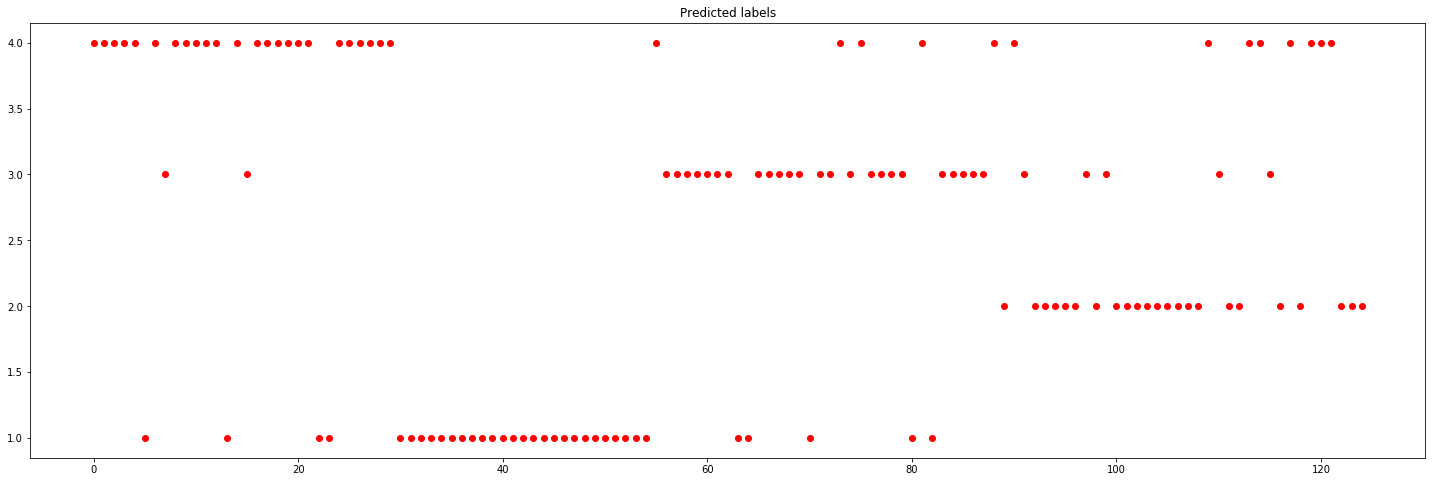

In [24]:
plt.figure(figsize=(25,8))
plt.plot(range(125),y,'o', color ='red')
plt.title('Predicted labels')

In [31]:
def smooth_labels (series,neighbors):
    '''this function takes a dataframe series corresponding to the predicted labels
    and a number of neighbor labels to smooth the predicted labels based on the fact that movements
    last at least a couple of seconds. It returns a smoothed list of labels'''
    smooth_labels = []
    neighbors = neighbors
    smooth_labels[0:0] = series.loc[0:neighbors]
    series = series.values    
    for i in range (neighbors,len(series)-neighbors):
        if any(x!=series[i] for x in smooth_labels[i-neighbors:i]) and any (y!=series[i] for y in series[i+1:i+1+neighbors]):
            smooth_labels.append(smooth_labels[i-neighbors])
            #smooth_labels.append(series[i+1])
            #smooth_labels.append(series[i+1])
        else:
            smooth_labels.append(series[i])
    for j in range (len(series)-neighbors,len(series)-1):
        smooth_labels.append(series[j])
    return smooth_labels

In [32]:
smth = smooth_labels(df_test_1hz.labels,2)

In [33]:
len(smth)

125

Text(0.5, 1.0, 'predicted vs smoothed labels')

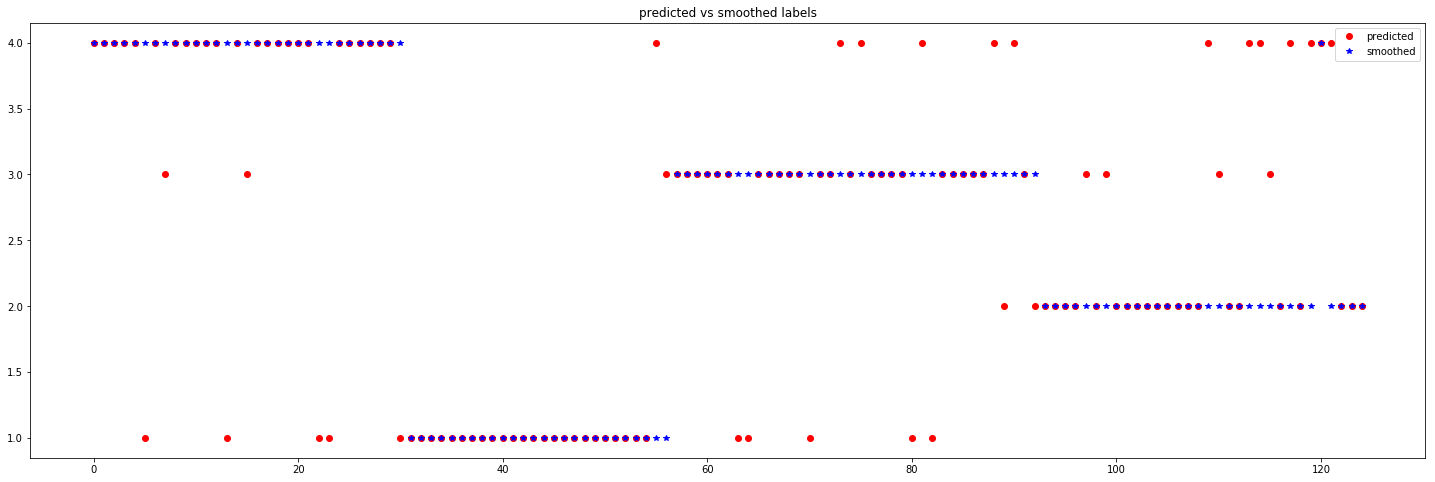

In [34]:
x = smth
plt.figure(figsize=(25,8))
plt.plot(range(125),y,'o', color ='red',label = 'predicted')
plt.plot(range(125),x,'*',color = 'blue',label = 'smoothed')
plt.legend()
plt.title('predicted vs smoothed labels')

In [35]:
print(smth)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2]
